In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer

In [4]:
df = pd.read_csv('../data/merged.csv')

In [82]:
X = df.drop(columns=['ruid', 'visit_id', 'admit_date', 'discharge_date', 'readmit_time', 
                     'total_encounters', 'dob', 'dod'])

## Training-Validation-Testing Split

In [83]:
train = X[X.group=='train']
valid = X[X.group=='valid']
test = X[X.group=='test']
assert(X.shape[0]==(train.shape[0] + valid.shape[0] + test.shape[0]))

In [84]:
y_train = train.pop('readmit_30d')
X_train = train.copy()
X_train.drop(columns='group', inplace=True)

In [85]:
y_valid = valid.pop('readmit_30d')
X_valid = valid.copy()
X_valid.drop(columns='group', inplace=True)

In [86]:
y_test = test.pop('readmit_30d')
X_test = test.copy()
X_test.drop(columns='group', inplace=True)

In [87]:
y_train.value_counts()/y_train.shape[0]

0    0.72754
1    0.27246
Name: readmit_30d, dtype: float64

In [88]:
y_valid.value_counts()/y_valid.shape[0]

0    0.740481
1    0.259519
Name: readmit_30d, dtype: float64

In [89]:
y_test.value_counts()/y_test.shape[0]

0    0.732797
1    0.267203
Name: readmit_30d, dtype: float64

## Patterns of Missingness

In [1]:
%load_ext rpy2.ipython
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
#%R install.packages('rms', dependencies=T)

In [2]:
%R library(rms); library(dplyr); library(data.table)

array(['data.table', 'dplyr', 'rms', 'SparseM', 'Hmisc', 'ggplot2',
       'Formula', 'survival', 'lattice', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U10')

In [132]:
%%R -i X_train
# ensure all variables have appropriate R structures
#X_train <- data.frame(sapply(X_train, as.numeric))
X_train$sex <- as.factor(X_train$sex)
X_train$race <- as.factor(X_train$race)
X_train$pregnancy_indicator <- as.factor(X_train$pregnancy_indicator)

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [133]:
%%R 
na.patterns.all <- naclus(X_train)

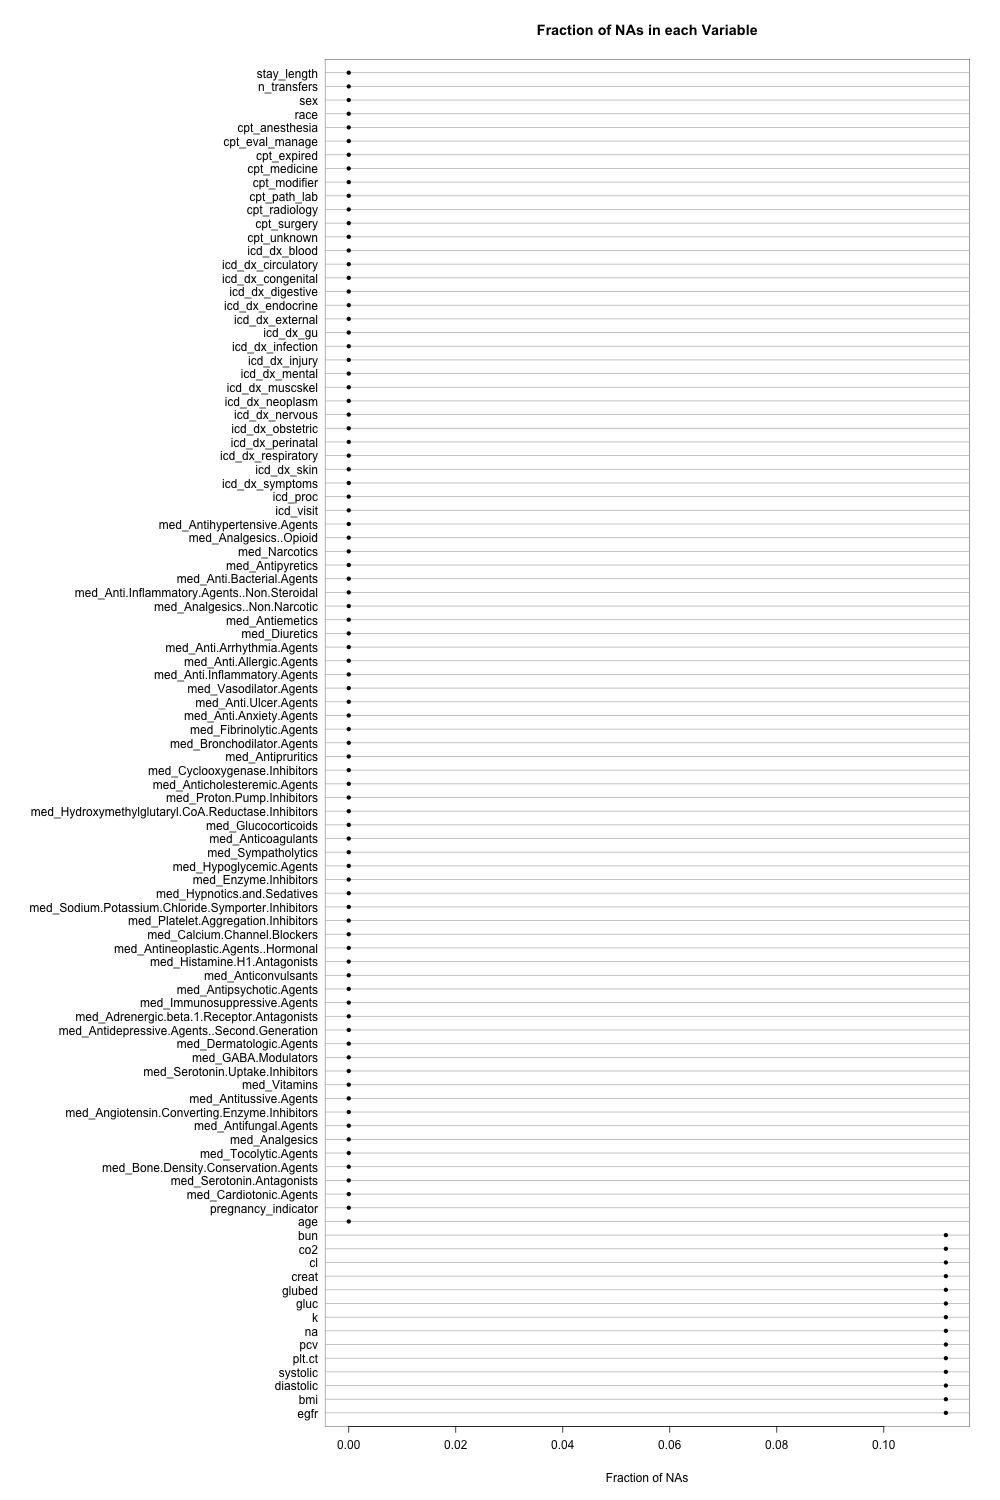

In [134]:
%%R -h 1500 -w 1000 -u px
naplot(na.patterns.all, which='na per var')

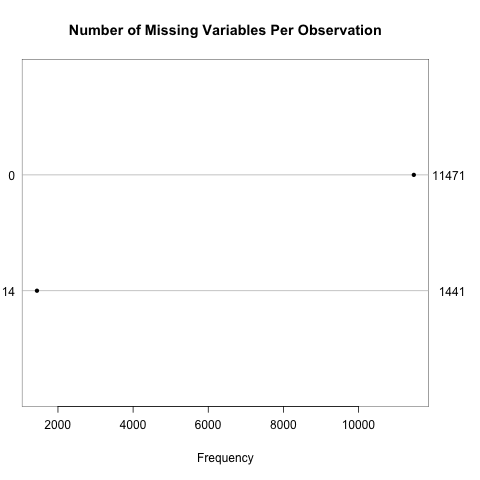

In [135]:
%%R -h 480 -w 480 -u px
naplot(na.patterns.all, which='na per obs')

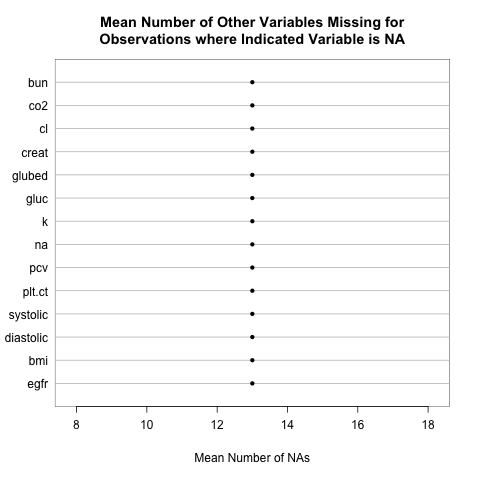

In [136]:
%%R -h 480 -w 480 -u px
naplot(na.patterns.all, which='mean na')

In [155]:
%%R

# separate categorical & numerical features
cat_cols <- c('sex', 'race', 'pregnancy_indicator')
num_cols <- names(X_train[, !names(X_train) %in% cat_cols])

# convert all predictors into R formula
vars <- paste(num_cols, collapse=' + ')
formula <- paste('~', vars)

# attempting all variables (but singular matrix resulted)
#formula <- as.formula(paste(formula), ' + sex-1 + race-1 + pregnancy_indicator-1'))

# numerical values only
formula <- as.formula(paste(formula))

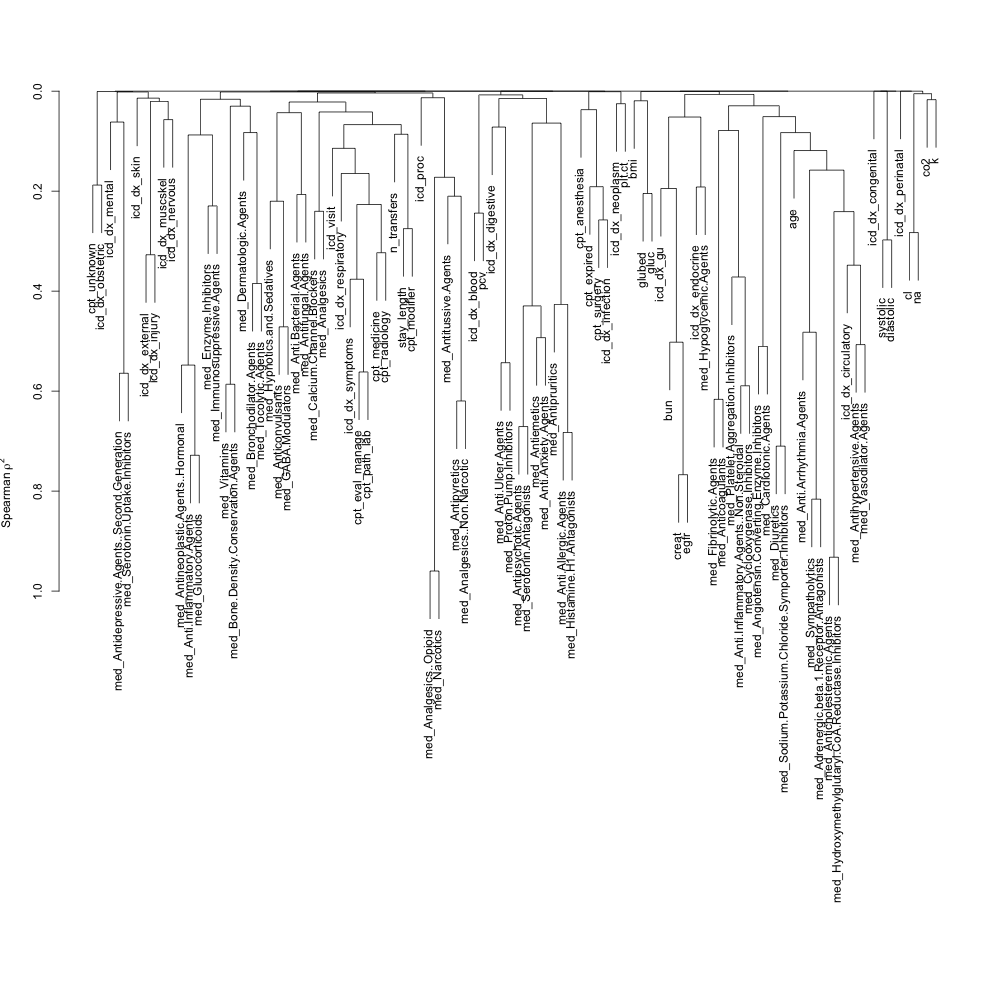

In [156]:
%%R -h 1000 -w 1000 -u px

vc <- varclus(formula, sim='spearman', data=X_train)
plot(vc) 

## Imputation

In [ ]:
%%R 
# convert all predictors into R formula
vars <- paste(names(X_train), collapse=' + ')
formula <- as.formula(paste('~', vars))

# perform single imputation using transformed variables & canonical correlation
single_imp <- transcan(formula,
                       categorical=c('sex', 'race', 'pregnancy_indicator'),
                       # variables with fewer than 3 unique knots
                       asis=c('icd_dx_perinatal', 'icd_dx_skin'),
                       transformed=TRUE, 
                       imputed=TRUE, 
                       # if wanting multiple imputations rather than a single:
                       #n.impute=5, 
                       show.na=TRUE, 
                       data=X_train)

In [125]:
%R summary(single_imp)

transcan(x = formula, categorical = c("sex", "race"), asis = c("pregnancy_indicator", 
    "icd_dx_perinatal", "icd_dx_skin"), imputed = TRUE, transformed = TRUE, 
    show.na = TRUE, data = X_train)

Iterations: 50 

R-squared achieved in predicting each variable:

                                       stay_length 
                                             0.876 
                                       n_transfers 
                                             0.607 
                                               sex 
                                             0.395 
                                              race 
                                             0.313 
                                    cpt_anesthesia 
                                             0.155 
                                   cpt_eval_manage 
                                             0.891 
                                       cpt_expired 
                                             0.774 
     

In [ ]:
%%R -o X_train_imp
X_train_imp <- impute(single_imp)

## Pickle Sets